In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import os
import numpy as np

In [6]:
batch_size=20

In [3]:
hdf5_path = 'data/dms_phases.h5'
hdf5_file = h5py.File(hdf5_path, "r")
X = np.array(hdf5_file["train_img"])
Y = np.array(hdf5_file['train_labels'])[:X.shape[0]]

In [5]:
! pip install pandas

In [14]:
! pip install scikit-learn

     |████████████████████████████████| 7.1MB 6.9MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/28/5c/cf6a2b65a321c4a209efcdf64c2689efae2cb62661f8f6f4bb28547cf1bf/joblib-0.14.1-py2.py3-none-any.whl


In [41]:
from sklearn.model_selection import train_test_split

paths = list(Path('/home/lhs18285/git/ml-cloud/data/pixbox-2/').glob('S3A*'))
paths = list(map(str, paths))
train_paths, test_paths = train_test_split(paths, test_size=.2)

In [42]:
for p in train_paths:
    src = p
    des = Path('/home/lhs18285/git/benchmarks/data/slstr_cloud/train/') / Path(p).name
    
    ! cp -R $src $des

In [ ]:
for p in test_paths:
    src = p
    des = Path('/home/lhs18285/git/benchmarks/data/slstr_cloud/test/') / Path(p).name
    
    ! cp -R $src $des

In [22]:
train_path = Path('/home/lhs18285/git/benchmarks/data/dms_classifier/train')
test_path = Path('/home/lhs18285/git/benchmarks/data/dms_classifier/test')

train_path.mkdir(exist_ok=True)
test_path.mkdir(exist_ok=True)

from sklearn.model_selection import train_test_split
train_img, test_img, train_labels, test_labels = train_test_split(imgs, labels, test_size=.2)

In [28]:
train_img.shape, test_img.shape

((6448, 487, 195, 3), (1612, 487, 195, 3))

In [26]:
import h5py

with h5py.File(train_path / 'dms_phases.h5', 'w') as f:
    f.create_dataset("images", data=train_img)
    f.create_dataset("labels", data=train_labels)
    
with h5py.File(test_path / 'dms_phases.h5', 'w') as f:
    f.create_dataset("images", data=test_img)
    f.create_dataset("labels", data=test_labels)

In [4]:
X.shape, Y.shape

((16867, 400, 400, 3), (16867, 10))

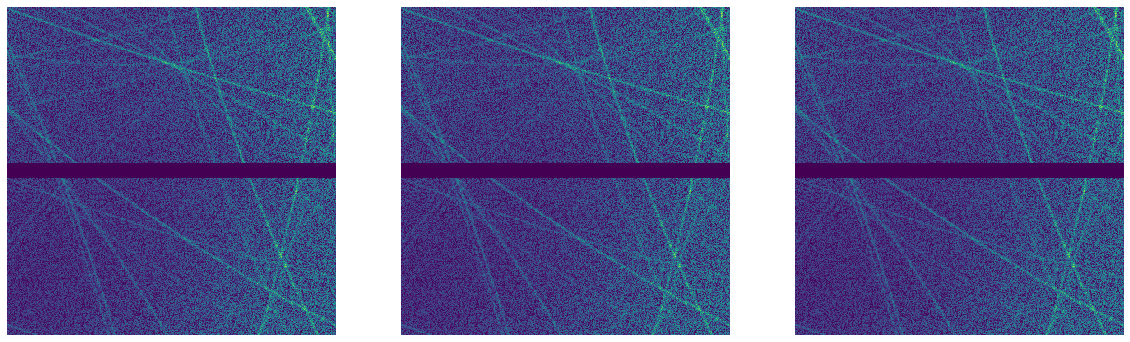

In [35]:
single_example = X[0]

fig, axes = plt.subplots(1, 3, figsize=(20,10))
[axi.set_axis_off() for axi in axes.ravel()]
ax1, ax2, ax3 = axes
ax1.matshow(single_example[..., 0])
ax2.matshow(single_example[..., 1])
ax3.matshow(single_example[..., 2])

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.shuffle(len(X))
dataset = dataset.batch(batch_size)

In [8]:
def small_cnn_classify(img_height, img_width, n_channels=3, n_classes=2):
    """
    A very basic setup of a small CNN for testing on classification problems
    Args:
        img_height: the height of the image in pixels (int)
        img_width: the width of the image in pixels (int)
    n_classes: number of clsses
    Returns:
        model: a Keras model
    """
    model = tf.keras.Sequential()
#create model
    model.add(tf.keras.layers.Conv2D(8, kernel_size=(4, 4),
                     activation='relu',
                     input_shape=(img_width, img_height, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(16, kernel_size=(2, 2), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    return model


In [36]:

n_classes = 10
batch_size=20
val_steps = 500
samples = 15000
epochs=5
img_height=400
img_width= 400
nworkers = 4
channels = 3
target_size=(img_width, img_height)

model = small_cnn_classify(target_size[1], target_size[0], channels, n_classes=n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(dataset, epochs=epochs)

Train for 844 steps
Epoch 1/5
 79/844 [=>............................] - ETA: 7:06 - loss: 2.5716 - accuracy: 0.1032

KeyboardInterrupt: 